In [1]:
import math
import numpy as np
from NoiseModel import NoiseModel
import matplotlib.pyplot as plt
import palettable

colors = palettable.colorbrewer.qualitative.Dark2_4.mpl_colors
import matplotlib 
matplotlib.rcParams.update({'font.size': 12})



In [2]:
def optAper(Tmag):
    
    # this eq. is from the TIC paper. I think it returns to number of pixels in the aperture, which is what I want. 
    Cs = [-0.2592, 7.7410, -77.7918, 274.2898]
    p = np.poly1d(Cs)
    optAper = round(p(Tmag))
    if optAper < 4: 
        optAper = 4
        
    return optAper # noise calculation needs AREA in aperture (in pixels sq.)


In [12]:
nfc = True

def snr_calcs(srad, smass, prad=1,
             tmags = np.arange(6,16.5, 0.25),  
             contratios = [0, 0.3, 0.6],
             pointprecision=False,
             Texp=2.):
    
    labels = ["CR = {0}".format(i) for i in contratios]
    
    try:
        prad1 = prad[0]
        prad2 = prad[1]
    except:
        prad1 = prad
        prad2 = prad
        
    try:
        texp1 = Texp[0]
        texp2 = Texp[1]
    except:
        texp1 = Texp
        texp2 = Texp
    
    HotJ = np.zeros((len(contratios),len(tmags)))
    BigE = np.zeros((len(contratios),len(tmags)))
    for i, Tmag in enumerate(tmags):
        myNM = NoiseModel(Tmag, texp1*60, optAper(Tmag), fracflux=0.8, unit='fraction')
        
        myNM.add_transit(srad=srad, smass=smass, prad=prad1, period=10.)
        for j, c in enumerate(contratios):
            y = myNM.calc_snr(contratio=c, noisefromcontam=True, pointprecision=pointprecision)
            HotJ[j,i] = y
        
        if Tmag == 13:
            print myNM.transit_duration
            print "T in transit", myNM.transit_duration * myNM.ntransits

        myNM.Texp = texp2*60
        myNM.add_transit(srad=srad, smass=smass, prad=prad2, period=0.8, b=0.)
        for j, c in enumerate(contratios):
            y = myNM.calc_snr(contratio=c, noisefromcontam=True, pointprecision=pointprecision)
            BigE[j,i] = y
            
        if Tmag == 13:
            print "T duration (0.8 days)", myNM.transit_duration
            print "T in transit", myNM.transit_duration * myNM.ntransits
    
    return HotJ, BigE, tmags, labels, contratios

In [4]:

def snr_plot(smass = 1, srad = 1, starname='the Sun', 
             prad=[1,1], planetname='Jupiter', 
             plottitle=None, legloc='best',
             savefig=False):
    
    HotJ, BigE, tmags, labels, contratios = snr_calcs(srad, smass, prad)

    plt.figure()  
    for j in range(0, len(contratios)):
        plt.plot(tmags, HotJ[j,:], label='P=10. d, '+labels[j], c=colors[j])

    for j in range(0, len(contratios)):
        plt.plot(tmags, BigE[j,:], label='P=0.8 d, '+labels[j], linestyle=':', c=colors[j])

    plt.ylim(0,40)
    plt.plot(plt.xlim(), [7.1,7.1], c='k')
    plt.text(10.25, 6.25, 'Detection limit: S/N=7.1', verticalalignment='top')
    plt.xlim(tmags[0], tmags[-1])
    
    plt.xlabel('TESS magnitude')
    plt.ylabel('S/N estimate')
    if plottitle is None:
        plottitle = 'Detectability of a {0} around {1}'.format(planetname, starname)
    plt.title(plottitle)
    
    leg = plt.legend(loc=legloc, fontsize=11)
    leg.get_frame().set_alpha(0.5)
    plt.tight_layout()
    
    if savefig:
        figtitle = 'outputs/planet_detection_plots/SorcerTESS_{0}_{1}.eps'.format(planetname, starname)
        plt.savefig("".join(figtitle.split()))
    else:
        plt.show()

In [10]:
def pp_plot(smass = 1, srad = 1, starname='the Sun', 
             prad=1, planetname='Jupiter',
             Texp=[30,10],
             plottitle=None, legloc='best',
             savefig=False):
    
    HotJ, BigE, tmags, labels, contratios = snr_calcs(srad, smass, prad, Texp=Texp, pointprecision=True)
    plt.figure()  
    for j in range(0, len(contratios)):
        plt.plot(tmags, HotJ[j,:], label=str(int(Texp[0]))+"min, "+labels[j], c=colors[j])

    for j in range(0, len(contratios)):
        plt.plot(tmags, BigE[j,:], label=str((Texp[1]))+"min, "+labels[j], linestyle=':', c=colors[j])

    plt.ylim(0,10)
    plt.plot(plt.xlim(), [3, 3], c='k')
    plt.text(13.6, 2.8, 'Detection limit: S/N=3', verticalalignment='top')
    plt.xlim(tmags[0], tmags[-1])
    
    plt.xlabel('TESS magnitude')
    plt.ylabel('S/N estimate for a single datum')
    if plottitle is None:
        plottitle = 'Detectability of a {0} around {1}'.format(planetname, starname)
    plt.title(plottitle)
    
    leg = plt.legend(loc=legloc, fontsize=11)
    leg.get_frame().set_alpha(0.5)
    plt.tight_layout()
    
    if savefig:
        figtitle = 'outputs/planet_detection_plots/SorcerTESS_singlepoint_{0}.eps'.format(starname)
        plt.savefig("".join(figtitle.split()))
    else:
        plt.show()

4.30302471372
T in transit 8.60604942745
T duration (0.8 days) 1.88277711879
T in transit 62.1316449201


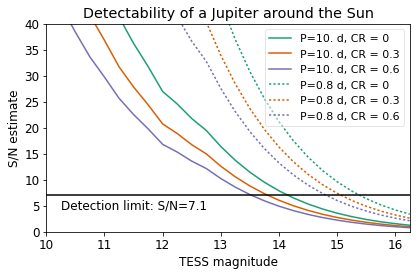

In [13]:
snr_plot(1, 1, 'the Sun', prad=[1,1], savefig=False)

In [64]:
snr_plot(.82, .725, 'eps Eri', legloc='center left', savefig=True)

0.00977392991321 6e-05
0.0190249702735
1.94650160605


In [7]:
snr_plot(.7, .665, '61 Cyg', 
        prad=[0.83,0.83], planetname='Saturn', 
        legloc='center left', savefig=True)

1.87769338952
T in transit 3.75538677903
T duration (0.8 days) 0.811373457503
T in transit 26.7753240976


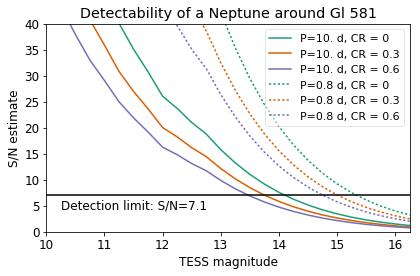

In [14]:
snr_plot(.31, .29, 'Gl 581', 
         prad=[0.35,0.35], planetname='Neptune', 
         legloc='upper right', savefig=False)

0.926591159655
T in transit 1.85318231931
T duration (0.8 days) 0.399530752444
T in transit 13.1845148307


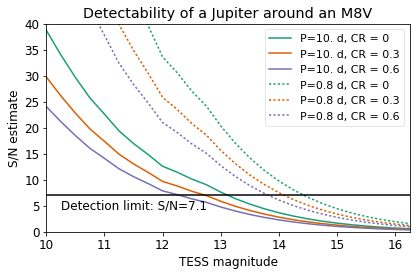

In [15]:
snr_plot(0.1, 0.1, 'an M8V', prad=[0.1,0.1], savefig=False)

4.30302471372
T in transit 4.30302471372
T duration (0.8 days) 1.88277711879
T in transit 1.88277711879


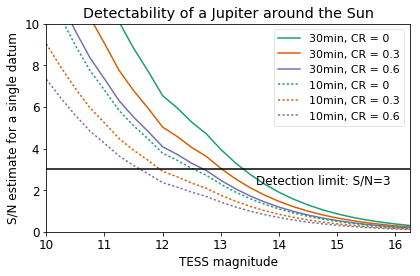

In [19]:
pp_plot(1, 1, 'the Sun', Texp=[30,10], prad=1, savefig=False)

1.87769338952
T in transit 1.87769338952
T duration (0.8 days) 0.811373457503
T in transit 0.811373457503


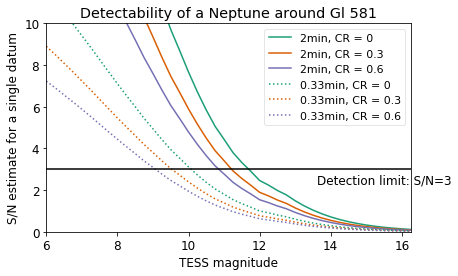

In [13]:
pp_plot(.31, .29, 'Gl 581', Texp=[2,0.33],
         prad=0.35, planetname='Neptune', 
         legloc='upper right', savefig=False)

2.25333192727
T in transit 2.25333192727
T duration (0.8 days) 0.97492004109
T in transit 0.97492004109


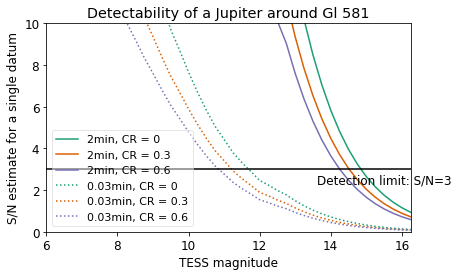

In [19]:
pp_plot(.31, .29, 'Gl 581', Texp=[2,0.03],
         prad=1., planetname='Jupiter', 
         legloc='lower left', savefig=False)

2.25333192727
T in transit 2.25333192727
T duration (0.8 days) 0.97492004109
T in transit 0.97492004109


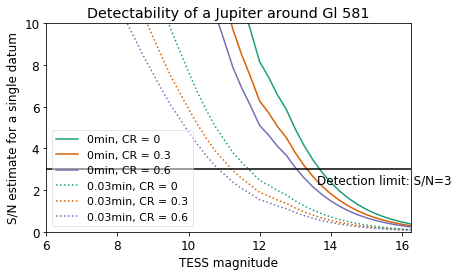

In [20]:
pp_plot(.31, .29, 'Gl 581', Texp=[0.33,0.03],
         prad=1., planetname='Jupiter', 
         legloc='lower left', savefig=False)